**Kütüphane Import**

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
#import catboost as cat
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

**Verileri İçeri Aktarma**

In [3]:
train_df = pd.read_csv('/content/gdrive/MyDrive/ÜNİVERSİTE/Yüksek Lisans/Uğur Şevik - Projeler/DIABETIC RETINOPATHY - TUBİTAK/Veriler/train.csv',sep=',') # sep verilerin nasıl ayrıldığını belirtir.

In [4]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

94765736/94765736 [==============================] - 6s 0us/step


In [5]:
def extract_features_resnet(img_path):
    img = image.load_img(img_path, target_size=(400, 400))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = resnet_model.predict(x)
    return features.flatten()

In [6]:
train_features_resnet = np.array([extract_features_resnet("/content/gdrive/MyDrive/ÜNİVERSİTE/Yüksek Lisans/Uğur Şevik - Projeler/DIABETIC RETINOPATHY - TUBİTAK/Veriler/train_images_processed/" + img_name + ".png") for img_name in train_df["id_code"]])

1/1 [==============================] - 0s 25ms/step


TypeError: 'numpy.ndarray' object is not callable

**Normalizasyon ve Veri Ayırma**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
n_train_features = scaler.fit_transform(train_features_resnet)

In [ ]:
y_train = train_df["diagnosis"]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(n_train_features, y_train, test_size=0.2,shuffle=True, random_state=42)

**MODELLER**

**1-Random Forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=250, max_depth=8, min_samples_split=5, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=5, n_estimators=250)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Eğitim ve doğrulama kümesinde tahmin yapma
train_predictions = rf.predict(X_train)
val_predictions = rf.predict(X_val)

# Eğitim ve doğrulama kümesinde metrikleri hesaplama
train_precision = precision_score(y_train, train_predictions, average='weighted')
val_precision = precision_score(y_val, val_predictions, average='weighted')

train_recall = recall_score(y_train, train_predictions, average='weighted')
val_recall = recall_score(y_val, val_predictions, average='weighted')

train_f1 = f1_score(y_train, train_predictions, average='weighted')
val_f1 = f1_score(y_val, val_predictions, average='weighted')

print("Eğitim kümesi kesinlik (precision):", train_precision)
print("Doğrulama kümesi kesinlik (precision):", val_precision)
print("Eğitim kümesi duyarlılık (recall):", train_recall)
print("Doğrulama kümesi duyarlılık (recall):", val_recall)
print("Eğitim kümesi F1-score:", train_f1)
print("Doğrulama kümesi F1-score:", val_f1)

Eğitim kümesi kesinlik (precision): 0.9354725512539824
Doğrulama kümesi kesinlik (precision): 0.6929179338601859
Eğitim kümesi duyarlılık (recall): 0.9327415500170707
Doğrulama kümesi duyarlılık (recall): 0.6916780354706685
Eğitim kümesi F1-score: 0.9331360067790303
Doğrulama kümesi F1-score: 0.6663909065289947


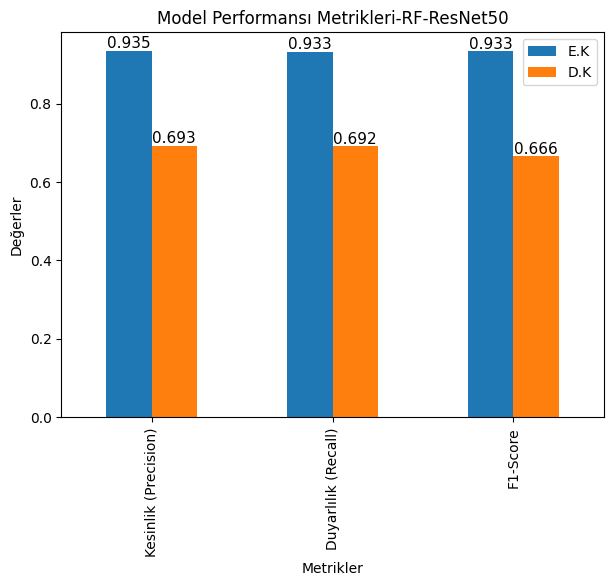

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Verileri bir sözlük olarak tanımla
data = {
    "Metrikler": ["Kesinlik (Precision)", "Duyarlılık (Recall)", "F1-Score"],
    "Eğitim Kümesi": [0.9354725512539824, 0.9327415500170707, 0.9331360067790303],
    "Doğrulama Kümesi": [0.6929179338601859, 0.691678035470668, 0.6663909065289947]
}

# Verileri bir DataFrame'e dönüştür
df = pd.DataFrame(data)

# Grafik oluştur
plt.figure(figsize=(7, 5))

# Çubuk grafik çiz
ax = df.plot(x="Metrikler", kind="bar", ax=plt.gca())

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    ax.annotate("{:.3f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Eksen etiketlerini ve başlığı ekle
plt.xlabel("Metrikler")
plt.ylabel("Değerler")
plt.title("Model Performansı Metrikleri-RF-ResNet50")

# Lejantı özelleştir
plt.legend(labels=['E.K', 'D.K'])

# Grafik penceresini göster
plt.show()

In [ ]:
train_f1_per_class = f1_score(y_train, train_predictions, average=None)
val_f1_per_class = f1_score(y_val, val_predictions, average=None)

for i, f1_train in enumerate(train_f1_per_class):
    print("Sınıf {} için eğitim kümesi F1-score: {:.4f}".format(i, f1_train))

for i, f1_val in enumerate(val_f1_per_class):
    print("Sınıf {} için doğrulama kümesi F1-score: {:.4f}".format(i, f1_val))

Sınıf 0 için eğitim kümesi F1-score: 0.9365
Sınıf 1 için eğitim kümesi F1-score: 0.9493
Sınıf 2 için eğitim kümesi F1-score: 0.8985
Sınıf 3 için eğitim kümesi F1-score: 0.9781
Sınıf 4 için eğitim kümesi F1-score: 0.9784
Sınıf 0 için doğrulama kümesi F1-score: 0.8810
Sınıf 1 için doğrulama kümesi F1-score: 0.4407
Sınıf 2 için doğrulama kümesi F1-score: 0.6401
Sınıf 3 için doğrulama kümesi F1-score: 0.1667
Sınıf 4 için doğrulama kümesi F1-score: 0.1067


In [ ]:
train_accuracy = svm.score(X_train, y_train)
val_accuracy = svm.score(X_val, y_val)
print("Eğitim kümesi doğruluğu:", train_accuracy)
print("Doğrulama kümesi doğruluğu:", val_accuracy)

Eğitim kümesi doğruluğu: 0.9184021850460908
Doğrulama kümesi doğruluğu: 0.7421555252387448


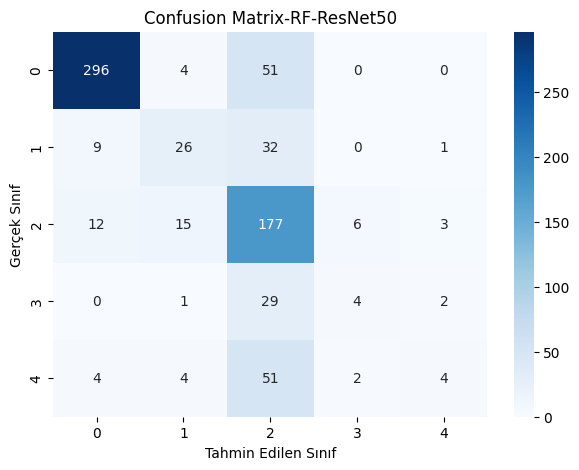

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = rf.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrix-RF-ResNet50")
plt.show()


**2-KNN Algoritması**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5,weights='distance')
knn.fit(X_train,y_train)

KNeighborsClassifier(weights='distance')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Eğitim ve doğrulama kümesinde tahmin yapma
train_predictions = knn.predict(X_train)
val_predictions = knn.predict(X_val)

# Eğitim ve doğrulama kümesinde metrikleri hesaplama
train_precision = precision_score(y_train, train_predictions, average='weighted')
val_precision = precision_score(y_val, val_predictions, average='weighted')

train_recall = recall_score(y_train, train_predictions, average='weighted')
val_recall = recall_score(y_val, val_predictions, average='weighted')

train_f1 = f1_score(y_train, train_predictions, average='weighted')
val_f1 = f1_score(y_val, val_predictions, average='weighted')

print("Eğitim kümesi kesinlik (precision):", train_precision)
print("Doğrulama kümesi kesinlik (precision):", val_precision)
print("Eğitim kümesi duyarlılık (recall):", train_recall)
print("Doğrulama kümesi duyarlılık (recall):", val_recall)
print("Eğitim kümesi F1-score:", train_f1)
print("Doğrulama kümesi F1-score:", val_f1)

Eğitim kümesi kesinlik (precision): 0.9931879759196538
Doğrulama kümesi kesinlik (precision): 0.6507794158437789
Eğitim kümesi duyarlılık (recall): 0.9931717309662
Doğrulama kümesi duyarlılık (recall): 0.6821282401091405
Eğitim kümesi F1-score: 0.993149688899753
Doğrulama kümesi F1-score: 0.6610424052616883


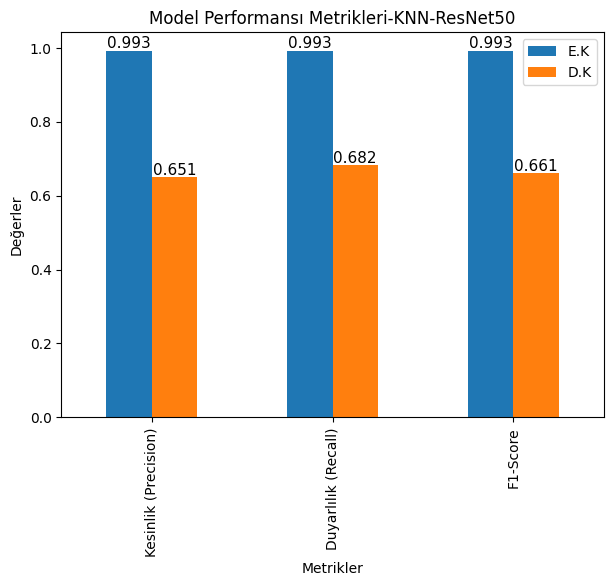

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Verileri bir sözlük olarak tanımla
data = {
    "Metrikler": ["Kesinlik (Precision)", "Duyarlılık (Recall)", "F1-Score"],
    "Eğitim Kümesi": [0.9931879759196538, 0.9931717309662, 0.993149688899753],
    "Doğrulama Kümesi": [0.6507794158437789, 0.6821282401091405, 0.6610424052616883]
}

# Verileri bir DataFrame'e dönüştür
df = pd.DataFrame(data)

# Grafik oluştur
plt.figure(figsize=(7, 5))

# Çubuk grafik çiz
ax = df.plot(x="Metrikler", kind="bar", ax=plt.gca())

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    ax.annotate("{:.3f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Eksen etiketlerini ve başlığı ekle
plt.xlabel("Metrikler")
plt.ylabel("Değerler")
plt.title("Model Performansı Metrikleri-KNN-ResNet50")

# Lejantı özelleştir
plt.legend(labels=['E.K', 'D.K'])

# Grafik penceresini göster
plt.show()

In [ ]:
train_f1_per_class = f1_score(y_train, train_predictions, average=None)
val_f1_per_class = f1_score(y_val, val_predictions, average=None)

for i, f1_train in enumerate(train_f1_per_class):
    print("Sınıf {} için eğitim kümesi F1-score: {:.4f}".format(i, f1_train))

for i, f1_val in enumerate(val_f1_per_class):
    print("Sınıf {} için doğrulama kümesi F1-score: {:.4f}".format(i, f1_val))

Sınıf 0 için eğitim kümesi F1-score: 0.9990
Sınıf 1 için eğitim kümesi F1-score: 0.9884
Sınıf 2 için eğitim kümesi F1-score: 0.9918
Sınıf 3 için eğitim kümesi F1-score: 0.9776
Sınıf 4 için eğitim kümesi F1-score: 0.9779
Sınıf 0 için doğrulama kümesi F1-score: 0.9132
Sınıf 1 için doğrulama kümesi F1-score: 0.3448
Sınıf 2 için doğrulama kümesi F1-score: 0.6009
Sınıf 3 için doğrulama kümesi F1-score: 0.1818
Sınıf 4 için doğrulama kümesi F1-score: 0.0930


In [ ]:
train_accuracy = knn.score(X_train, y_train)
val_accuracy = knn.score(X_val, y_val)
print("Eğitim kümesi doğruluğu:", train_accuracy)
print("Doğrulama kümesi doğruluğu:", val_accuracy)

Eğitim kümesi doğruluğu: 0.9931717309662
Doğrulama kümesi doğruluğu: 0.6821282401091405


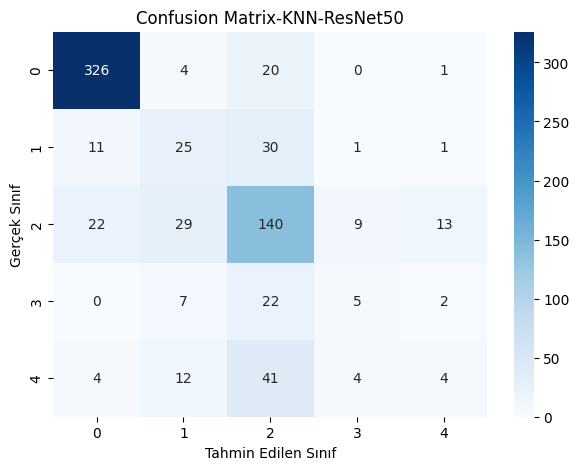

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = knn.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrix-KNN-ResNet50")
plt.show()

**3-Adaboost Algoritması**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators = 100, learning_rate = 0.1, algorithm ='SAMME',random_state=42)
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=100,
                   random_state=42)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Eğitim ve doğrulama kümesinde tahmin yapma
train_predictions = ada.predict(X_train)
val_predictions = ada.predict(X_val)

# Eğitim ve doğrulama kümesinde metrikleri hesaplama
train_precision = precision_score(y_train, train_predictions, average='weighted')
val_precision = precision_score(y_val, val_predictions, average='weighted')

train_recall = recall_score(y_train, train_predictions, average='weighted')
val_recall = recall_score(y_val, val_predictions, average='weighted')

train_f1 = f1_score(y_train, train_predictions, average='weighted')
val_f1 = f1_score(y_val, val_predictions, average='weighted')

print("Eğitim kümesi kesinlik (precision):", train_precision)
print("Doğrulama kümesi kesinlik (precision):", val_precision)
print("Eğitim kümesi duyarlılık (recall):", train_recall)
print("Doğrulama kümesi duyarlılık (recall):", val_recall)
print("Eğitim kümesi F1-score:", train_f1)
print("Doğrulama kümesi F1-score:", val_f1)

Eğitim kümesi kesinlik (precision): 0.5875206372009377
Doğrulama kümesi kesinlik (precision): 0.5876207912118043
Eğitim kümesi duyarlılık (recall): 0.7063844315466029
Doğrulama kümesi duyarlılık (recall): 0.7094133697135061
Eğitim kümesi F1-score: 0.6298722333290923
Doğrulama kümesi F1-score: 0.6317133829001337


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


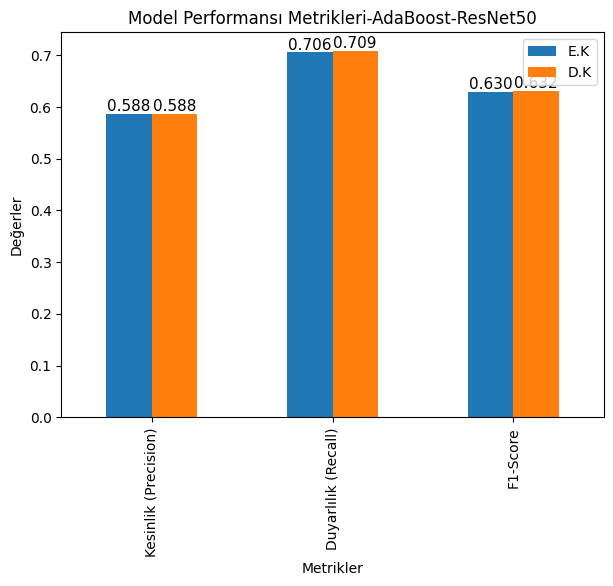

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Verileri bir sözlük olarak tanımla
data = {
    "Metrikler": ["Kesinlik (Precision)", "Duyarlılık (Recall)", "F1-Score"],
    "Eğitim Kümesi": [0.5875206372009377, 0.7063844315466029, 0.6298722333290923],
    "Doğrulama Kümesi": [0.5876207912118043, 0.7094133697135061, 0.6317133829001337]
}

# Verileri bir DataFrame'e dönüştür
df = pd.DataFrame(data)

# Grafik oluştur
plt.figure(figsize=(7, 5))

# Çubuk grafik çiz
ax = df.plot(x="Metrikler", kind="bar", ax=plt.gca())

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    ax.annotate("{:.3f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Eksen etiketlerini ve başlığı ekle
plt.xlabel("Metrikler")
plt.ylabel("Değerler")
plt.title("Model Performansı Metrikleri-AdaBoost-ResNet50")

# Lejantı özelleştir
plt.legend(labels=['E.K', 'D.K'])

# Grafik penceresini göster
plt.show()

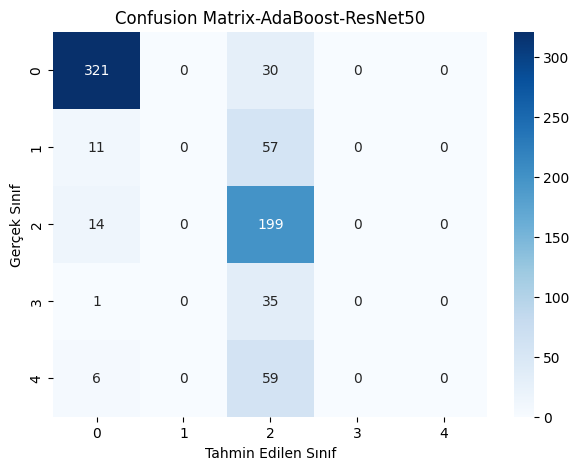

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = ada.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrix-AdaBoost-ResNet50")
plt.show()

**4-Naive Bayes Algoritmasaı**

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Eğitim ve doğrulama kümesinde tahmin yapma
train_predictions = nb.predict(X_train)
val_predictions = nb.predict(X_val)

# Eğitim ve doğrulama kümesinde metrikleri hesaplama
train_precision = precision_score(y_train, train_predictions, average='weighted')
val_precision = precision_score(y_val, val_predictions, average='weighted')

train_recall = recall_score(y_train, train_predictions, average='weighted')
val_recall = recall_score(y_val, val_predictions, average='weighted')

train_f1 = f1_score(y_train, train_predictions, average='weighted')
val_f1 = f1_score(y_val, val_predictions, average='weighted')

print("Eğitim kümesi kesinlik (precision):", train_precision)
print("Doğrulama kümesi kesinlik (precision):", val_precision)
print("Eğitim kümesi duyarlılık (recall):", train_recall)
print("Doğrulama kümesi duyarlılık (recall):", val_recall)
print("Eğitim kümesi F1-score:", train_f1)
print("Doğrulama kümesi F1-score:", val_f1)

Eğitim kümesi kesinlik (precision): 0.9789793887307435
Doğrulama kümesi kesinlik (precision): 0.5795953904243485
Eğitim kümesi duyarlılık (recall): 0.9788323659952202
Doğrulama kümesi duyarlılık (recall): 0.6098226466575716
Eğitim kümesi F1-score: 0.9787875952863755
Doğrulama kümesi F1-score: 0.5515250207353543


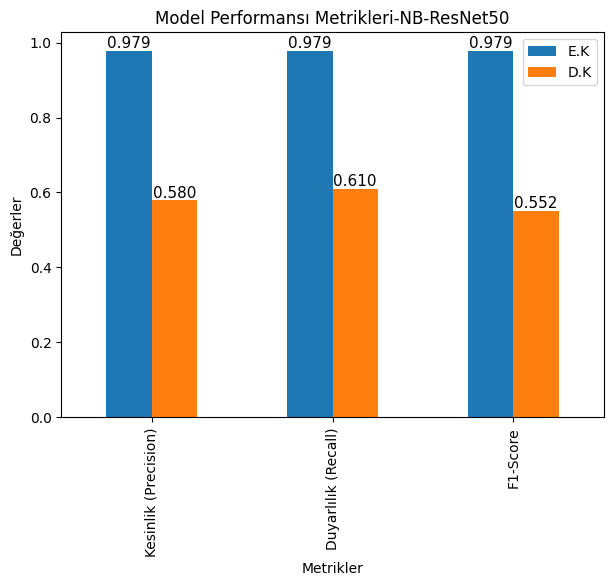

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Verileri bir sözlük olarak tanımla
data = {
    "Metrikler": ["Kesinlik (Precision)", "Duyarlılık (Recall)", "F1-Score"],
    "Eğitim Kümesi": [0.9789793887307435, 0.9788323659952202, 0.9787875952863755],
    "Doğrulama Kümesi": [0.5795953904243485, 0.6098226466575716, 0.5515250207353543]
}

# Verileri bir DataFrame'e dönüştür
df = pd.DataFrame(data)

# Grafik oluştur
plt.figure(figsize=(7, 5))

# Çubuk grafik çiz
ax = df.plot(x="Metrikler", kind="bar", ax=plt.gca())

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    ax.annotate("{:.3f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Eksen etiketlerini ve başlığı ekle
plt.xlabel("Metrikler")
plt.ylabel("Değerler")
plt.title("Model Performansı Metrikleri-NB-ResNet50")

# Lejantı özelleştir
plt.legend(labels=['E.K', 'D.K'])

# Grafik penceresini göster
plt.show()

In [ ]:
train_f1_per_class = f1_score(y_train, train_predictions, average=None)
val_f1_per_class = f1_score(y_val, val_predictions, average=None)

for i, f1_train in enumerate(train_f1_per_class):
    print("Sınıf {} için eğitim kümesi F1-score: {:.4f}".format(i, f1_train))

for i, f1_val in enumerate(val_f1_per_class):
    print("Sınıf {} için doğrulama kümesi F1-score: {:.4f}".format(i, f1_val))

Sınıf 0 için eğitim kümesi F1-score: 0.9866
Sınıf 1 için eğitim kümesi F1-score: 0.9805
Sınıf 2 için eğitim kümesi F1-score: 0.9671
Sınıf 3 için eğitim kümesi F1-score: 0.9752
Sınıf 4 için eğitim kümesi F1-score: 0.9697
Sınıf 0 için doğrulama kümesi F1-score: 0.7627
Sınıf 1 için doğrulama kümesi F1-score: 0.0811
Sınıf 2 için doğrulama kümesi F1-score: 0.5513
Sınıf 3 için doğrulama kümesi F1-score: 0.0930
Sınıf 4 için doğrulama kümesi F1-score: 0.1579


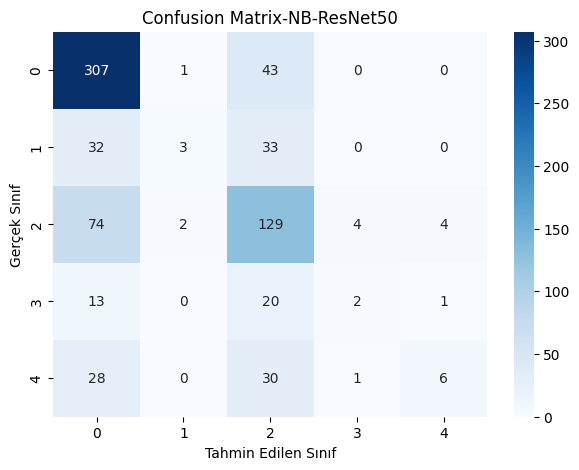

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = nb.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrix-NB-ResNet50")
plt.show()

**5-SVM Algoritması**

In [ ]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale')

In [ ]:
svm.fit(X_train, y_train)

SVC()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Eğitim ve doğrulama kümesinde tahmin yapma
train_predictions = svm.predict(X_train)
val_predictions = svm.predict(X_val)

# Eğitim ve doğrulama kümesinde metrikleri hesaplama
train_precision = precision_score(y_train, train_predictions, average='weighted')
val_precision = precision_score(y_val, val_predictions, average='weighted')

train_recall = recall_score(y_train, train_predictions, average='weighted')
val_recall = recall_score(y_val, val_predictions, average='weighted')

train_f1 = f1_score(y_train, train_predictions, average='weighted')
val_f1 = f1_score(y_val, val_predictions, average='weighted')

print("Eğitim kümesi kesinlik (precision):", train_precision)
print("Doğrulama kümesi kesinlik (precision):", val_precision)
print("Eğitim kümesi duyarlılık (recall):", train_recall)
print("Doğrulama kümesi duyarlılık (recall):", val_recall)
print("Eğitim kümesi F1-score:", train_f1)
print("Doğrulama kümesi F1-score:", val_f1)

Eğitim kümesi kesinlik (precision): 0.9281166631839078
Doğrulama kümesi kesinlik (precision): 0.7138463332575087
Eğitim kümesi duyarlılık (recall): 0.9184021850460908
Doğrulama kümesi duyarlılık (recall): 0.7421555252387448
Eğitim kümesi F1-score: 0.9144450856700053
Doğrulama kümesi F1-score: 0.6720048856876942


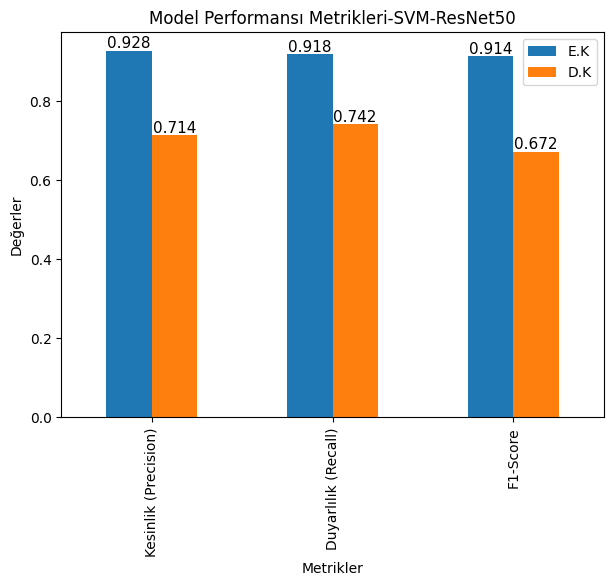

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Verileri bir sözlük olarak tanımla
data = {
    "Metrikler": ["Kesinlik (Precision)", "Duyarlılık (Recall)", "F1-Score"],
    "Eğitim Kümesi": [0.9281166631839078, 0.9184021850460908, 0.9144450856700053],
    "Doğrulama Kümesi": [0.7138463332575087, 0.7421555252387448, 0.6720048856876942]
}

# Verileri bir DataFrame'e dönüştür
df = pd.DataFrame(data)

# Grafik oluştur
plt.figure(figsize=(7, 5))

# Çubuk grafik çiz
ax = df.plot(x="Metrikler", kind="bar", ax=plt.gca())

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    ax.annotate("{:.3f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Eksen etiketlerini ve başlığı ekle
plt.xlabel("Metrikler")
plt.ylabel("Değerler")
plt.title("Model Performansı Metrikleri-SVM-ResNet50")

# Lejantı özelleştir
plt.legend(labels=['E.K', 'D.K'])

# Grafik penceresini göster
plt.show()

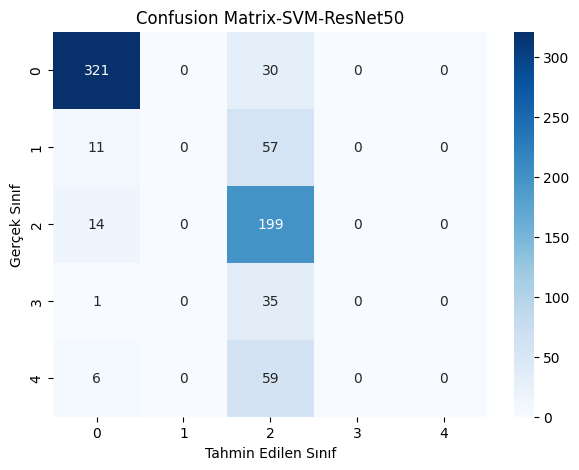

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = svm.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrix-SVM-ResNet50")
plt.show()